## Access Our Data

### 1. Download it from OneDrive using this [link](https://liveuclac-my.sharepoint.com/:f:/g/personal/ucabdsm_ucl_ac_uk/Ek8oM7sBaJhFs5Py5FPdtYEB_YW0TcEVvtjjdtNqp_Ud4A?e=Alw6kD). 
### 2. Move the 'comp0241_data.zip' file into the same directory as the current notebook and unzip it.
### 3. Make sure you have the 'comp0241_data' folder in this directory.
### 4. Run the code below.

# Task 1
##  Extract the Astronomical Object from Images

### a) Implement at Least Two Methods for AO Extraction
### b) Combine Methods for Improved Accuracy
### c) Evaluate Performance with ROC Curves

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os

def align_images_multiple_references(reference_image_paths, distorted_image_path):
    # Load the distorted image
    dist_img = cv2.imread(distorted_image_path)
    dist_gray = cv2.cvtColor(dist_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT
    sift = cv2.SIFT_create()

    # Aggregate keypoints and descriptors from all reference images
    ref_keypoints = []
    ref_descriptors = []
    for ref_path in reference_image_paths:
        ref_img = cv2.imread(ref_path)
        ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(ref_gray, None)
        ref_keypoints.extend(keypoints)
        if descriptors is not None:
            if len(ref_descriptors) == 0:
                ref_descriptors = descriptors
            else:
                ref_descriptors = np.vstack((ref_descriptors, descriptors))

    # Detect keypoints and descriptors in the distorted image
    keypoints_dist, descriptors_dist = sift.detectAndCompute(dist_gray, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(ref_descriptors, descriptors_dist)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched keypoints
    ref_pts = np.float32([ref_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dist_pts = np.float32([keypoints_dist[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Estimate homography
    matrix, mask = cv2.findHomography(dist_pts, ref_pts, cv2.RANSAC, 5.0)

    # Warp the distorted image
    h, w = dist_img.shape[:2]
    aligned_image = cv2.warpPerspective(dist_img, matrix, (w, h))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Distorted Image")
    plt.imshow(cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Aligned Image")
    plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return matrix

def transform_image_with_homography(image_path, homography_matrix):
    # Load the image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]  # Get the size from the image itself

    # Apply the homography transformation
    transformed_image = cv2.warpPerspective(image, homography_matrix, (w, h))

    return transformed_image

def reverse_transform_image_with_homography(transformed_image, homography_matrix):
    """
    Reverse the homography transformation on an image.

    Parameters:
        transformed_image: The image that was transformed.
        homography_matrix: The homography matrix used for the forward transformation.

    Returns:
        The reversed (original) image.
    """
    # Calculate the inverse of the homography matrix
    inverse_homography_matrix = np.linalg.inv(homography_matrix)
    
    # Get the size of the transformed image
    h, w = transformed_image.shape[:2]
    
    # Apply the inverse homography transformation
    original_image = cv2.warpPerspective(transformed_image, inverse_homography_matrix, (w, h))
    
    return original_image

def save_homography_matrix(matrix, file_path):
    # Convert the NumPy array to a list for JSON serialization
    matrix_list = matrix.tolist()
    with open(file_path, 'w') as f:
        json.dump(matrix_list, f)

def process_dataset_images(data_folder, dataset_folder):
    images_folder = os.path.join(dataset_folder, "images")
    
    if not os.path.exists(f'{data_folder}/calibrated-images'):
        os.makedirs(f'{data_folder}/calibrated-images')
        print(f"Directory created: {data_folder}/calibrated-images")
    else:
        print(f"Directory already exists: {data_folder}/calibrated-images")

    for image_name in os.listdir(images_folder):
        print(image_name)
        image_path = os.path.join(images_folder, image_name)

        reference_image_paths = [
            f'{dataset_folder}/images/000003.png', f'{dataset_folder}/images/000010.png', f'{dataset_folder}/images/000016.png', f'{dataset_folder}/images/000021.png', f'{dataset_folder}/images/000022.png', f'{dataset_folder}/images/000028.png', f'{dataset_folder}/images/000030.png', f'{dataset_folder}/images/000033.png', f'{dataset_folder}/images/000046.png', f'{dataset_folder}/images/000051.png', f'{dataset_folder}/images/000053.png', f'{dataset_folder}/images/000060.png', f'{dataset_folder}/images/000061.png', f'{dataset_folder}/images/000064.png',
            f'{dataset_folder}/images/000072.png', f'{dataset_folder}/images/000081.png', f'{dataset_folder}/images/000096.png', 
        ]  # Add more references
        #distorted_image_path = './Dataset 2/images/000083.png'
        homography_matrix = align_images_multiple_references(reference_image_paths, image_path)

        # Transform the image
        transformed_image = transform_image_with_homography(image_path, homography_matrix)

        if not cv2.imwrite(f"{data_folder}/calibrated-images/{image_name}", transformed_image):
            print(f"Failed to save image: {image_name}")

        save_homography_matrix(homography_matrix, f"{data_folder}/calibrated-images/{image_name.replace('png', 'json')}")

        # Plot the original and transformed images
        #original_image = cv2.imread(image_path)
        #plt.figure(figsize=(12, 6))
        #plt.subplot(1, 2, 1)
        #plt.title("Original Image")
        #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        #plt.axis("off")

        #plt.subplot(1, 2, 2)
        #plt.title("Transformed Image")
        #plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
        #plt.axis("off")

        #plt.tight_layout()
        #plt.show()

# Example usage
data_folder = './comp0241_data'
dataset_folder = f'{data_folder}/task_1_dataset'  # Replace with the actual dataset folder

process_dataset_images(data_folder, dataset_folder)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import json

def load_homography_matrix(file_path):
    # Load the JSON file and convert the list back to a NumPy array
    with open(file_path, 'r') as f:
        matrix_list = json.load(f)
    return np.array(matrix_list)

def reverse_transform_image_with_homography(transformed_image, homography_matrix):
    """
    Reverse the homography transformation on an image.

    Parameters:
        transformed_image: The image that was transformed.
        homography_matrix: The homography matrix used for the forward transformation.

    Returns:
        The reversed (original) image.
    """
    # Calculate the inverse of the homography matrix
    inverse_homography_matrix = np.linalg.inv(homography_matrix)
    
    # Get the size of the transformed image
    h, w = transformed_image.shape[:2]
    
    # Apply the inverse homography transformation
    original_image = cv2.warpPerspective(transformed_image, inverse_homography_matrix, (w, h))
    
    return original_image

def color_thresholding(image, lower_bounds, upper_bounds):
    """
    Perform color thresholding to segment the globe.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        lower_bounds (list of numpy.ndarray): List of lower HSV color bounds.
        upper_bounds (list of numpy.ndarray): List of upper HSV color bounds.

    Returns:
        numpy.ndarray: Binary mask highlighting the selected colors.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    # Apply each color threshold and combine the masks
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect a single circular shape in the image using a color mask to focus the detection.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        color_mask (numpy.ndarray): Binary mask obtained from color thresholding.

    Returns:
        numpy.ndarray: Binary mask with the detected circle.
    """
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    # Convert to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(blurred_image, cmap='gray')
    plt.title(f"Thresholding Result {i:06d}")
    plt.axis("off")
    plt.show()
    # Detect circles using HoughCircles with adjusted parameters
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )

    # Create a binary mask with the same dimensions as the input image
    mask = np.zeros_like(gray_image)
    if circles is not None:
        # Get the first (most prominent) circle
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask

def compute_roc_curve(predicted_mask, ground_truth_mask):
    """
    Compute ROC curve and AUC for a predicted mask and ground truth mask.

    Parameters:
        predicted_mask (numpy.ndarray): Predicted binary mask.
        ground_truth_mask (numpy.ndarray): Ground truth binary mask.

    Returns:
        tuple: (fpr, tpr, roc_auc) False Positive Rate, True Positive Rate, and Area Under Curve.
    """
    # Binarize the masks
    predicted_binary = (predicted_mask > 0).astype(np.uint8).flatten()
    ground_truth_binary = (ground_truth_mask > 0).astype(np.uint8).flatten()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_binary, predicted_binary)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# Dataset paths
images_folder = './comp0241_data/task_1_dataset/images/'
corrected_images_folder = './comp0241_data/calibrated-images/'
masks_folder = './comp0241_data/task_1_dataset/masks/'

# Bounds for color thresholding
lower_bounds = [
    np.array([100, 50, 50]),  # Lower bound of blue in HSV
    np.array([0, 0, 200]),    # Lower bound of white in HSV
]
upper_bounds = [
    np.array([140, 255, 255]),  # Upper bound of blue in HSV
    np.array([180, 50, 255]),   # Upper bound of white in HSV
]

# Lists to store ROC values
all_fpr = []
all_tpr = []
all_auc = []

# Loop through all images and masks
for i in range(100):
    image_path = os.path.join(images_folder, f"{i:06d}.png")
    corrected_image_path = os.path.join(corrected_images_folder, f"{i:06d}.png")
    mask_path = os.path.join(masks_folder, f"{i:06d}.png")

    # Read image and ground truth mask
    image = cv2.imread(image_path)
    corrected_image = cv2.imread(corrected_image_path)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    loaded_matrix = load_homography_matrix(corrected_image_path.replace("png", "json"))

    # Generate color mask
    color_mask = color_thresholding(corrected_image, lower_bounds, upper_bounds)

    # Plot the thresholding result
    plt.figure(figsize=(6, 6))
    plt.imshow(color_mask, cmap='gray')
    plt.title(f"Thresholding Result {i:06d}")
    plt.axis("off")
    plt.show()

    # Refine circle detection with color mask
    predicted_mask = reverse_transform_image_with_homography(refined_circle_detection_with_mask(image, color_mask), loaded_matrix)

    if not cv2.imwrite(f"./comp0241_data/calibrated-images/{i:06d}_predicted_mask.png", predicted_mask):
            print(f"Failed to save {i:06d}_predicted_mask.png")

    # Compute ROC curve
    fpr, tpr, roc_auc = compute_roc_curve(predicted_mask, ground_truth_mask)

    # Store the results
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    # Plot image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i:06d}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Compute average ROC curve (mean TPR for each FPR)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(all_fpr, all_tpr):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr /= len(all_tpr)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot average ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.2f})")
plt.title("Average ROC Curve for Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Print mean AUC
print(f"Mean AUC: {mean_auc:.2f}")


In [ ]:
# Evaluate ROC for different solutions

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os

def color_thresholding(image, lower_bounds, upper_bounds):
    """
    Perform color thresholding to segment the globe.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        lower_bounds (list of numpy.ndarray): List of lower HSV color bounds.
        upper_bounds (list of numpy.ndarray): List of upper HSV color bounds.

    Returns:
        numpy.ndarray: Binary mask highlighting the selected colors.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    # Apply each color threshold and combine the masks
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect a single circular shape in the image using a color mask to focus the detection.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        color_mask (numpy.ndarray): Binary mask obtained from color thresholding.

    Returns:
        numpy.ndarray: Binary mask with the detected circle.
    """
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    # Convert to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    # Detect circles using HoughCircles with adjusted parameters
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    # Create a binary mask with the same dimensions as the input image
    mask = np.zeros_like(gray_image)
    if circles is not None:
        # Get the first (most prominent) circle
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask


def refined_ellipse_detection_with_mask(image, color_mask):
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Optional blur to reduce noise, adjust kernel size as needed
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)

    # Find contours
    contours, hierarchy = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)
    if len(contours) > 0:
        # Select the largest contour as AO
        largest_contour = max(contours, key=cv2.contourArea)
        
        # fitEllipse requires at least 5 points
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            
            # Draw the ellipse on the mask
            # ellipse: ((center_x, center_y), (axis1, axis2), angle)
            cv2.ellipse(mask, ellipse, 255, -1)
    
    return mask


def compute_roc_curve(predicted_mask, ground_truth_mask):
    """
    Compute ROC curve and AUC for a predicted mask and ground truth mask.

    Parameters:
        predicted_mask (numpy.ndarray): Predicted binary mask.
        ground_truth_mask (numpy.ndarray): Ground truth binary mask.

    Returns:
        tuple: (fpr, tpr, roc_auc) False Positive Rate, True Positive Rate, and Area Under Curve.
    """
    # Binarize the masks
    predicted_binary = (predicted_mask > 0).astype(np.uint8).flatten()
    ground_truth_binary = (ground_truth_mask > 0).astype(np.uint8).flatten()

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_binary, predicted_binary)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc


def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    """
    Perform edge detection using the Canny Edge Detector.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        low_threshold (int): Lower threshold for hysteresis. Default is 50.
        high_threshold (int): Upper threshold for hysteresis. Default is 150.

    Returns:
        numpy.ndarray: Binary mask highlighting edges.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 1)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges

def kmeans_thresholding(image, k=2, random_seed=42):
    """
    Perform thresholding using K-means clustering with fixed randomness for reproducibility.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        k (int): Number of clusters. Default is 2 for binary segmentation.
        random_seed (int): Random seed for K-means initialization. Default is 42.

    Returns:
        numpy.ndarray: Binary mask created using K-means clustering.
    """
    # Convert image to grayscale for simplicity
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Flatten the image into a 1D array
    pixel_values = gray_image.reshape((-1, 1)).astype(np.float32)

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Define criteria and apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixel_values, 
        k, 
        None, 
        criteria, 
        10, 
        cv2.KMEANS_RANDOM_CENTERS
    )

    # Reshape labels to match original image shape
    labels = labels.flatten()
    segmented_image = labels.reshape(gray_image.shape)

    # Create binary mask: assign 0 to the smaller cluster, 255 to the larger cluster
    binary_mask = np.where(segmented_image == segmented_image.max(), 255, 0).astype(np.uint8)

    return binary_mask

# Dataset paths
images_folder = './comp0241_data/task_1_dataset/images/'
corrected_images_folder = './comp0241_data/calibrated-images/'
masks_folder = './comp0241_data/task_1_dataset/masks/'

lower_bounds = [
    np.array([50, 23, 50]),  # Lower bound of blue in HSV
    np.array([0, 0, 200]),    # Lower bound of white in HSV
]
upper_bounds = [
    np.array([150, 255, 255]),  # Upper bound of blue in HSV
    np.array([180, 50, 0]),   # Upper bound of white in HSV
]

# Lists to store ROC values
all_fpr = []
all_tpr = []
all_auc = []

# Loop through all images and masks
for i in range(100):
    image_path = os.path.join(images_folder, f"{i:06d}.png")
    corrected_image_path = os.path.join(corrected_images_folder, f"{i:06d}.png")
    mask_path = os.path.join(masks_folder, f"{i:06d}.png")

    # Read image and ground truth mask
    image = cv2.imread(image_path)
    corrected_image = cv2.imread(corrected_image_path)
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    loaded_matrix = load_homography_matrix(corrected_image_path.replace("png", "json"))

    # Generate color mask
    # Thresholding 
    color_mask = color_thresholding(corrected_image, lower_bounds, upper_bounds)
    # K Means
    # color_mask = kmeans_thresholding(corrected_image)
    # # Canny Edge Detection
    # color_mask = canny_edge_detection(corrected_image)


    # Refine circle detection with color mask
    predicted_mask = reverse_transform_image_with_homography(refined_ellipse_detection_with_mask(image, color_mask), loaded_matrix)

    # Compute ROC curve
    fpr, tpr, roc_auc = compute_roc_curve(predicted_mask, ground_truth_mask)

    # Store the results
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)
    if roc_auc < 0.95:

        # Plot the thresholding result
        plt.figure(figsize=(6, 6))
        plt.imshow(color_mask, cmap='gray')
        plt.title(f"Thresholding Result {i:06d}")
        plt.axis("off")
        plt.show()

        print("Auc: ", roc_auc)
        # Plot image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i:06d}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Compute average ROC curve (mean TPR for each FPR)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(all_fpr, all_tpr):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr /= len(all_tpr)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot average ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.4f})")
plt.title("Average ROC Curve for Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# Compute and print AUC statistics
max_auc = max(all_auc)
min_auc = min(all_auc)
median_auc = np.median(all_auc)

print(f"Max AUC: {max_auc:.4f}")
print(f"Min AUC: {min_auc:.4f}")
print(f"Median AUC: {median_auc:.4f}")
print(f"Mean AUC: {mean_auc:.4f}")

# Example combined FPR and TPR data
combined_fpr = np.concatenate(all_fpr)
combined_tpr = np.concatenate(all_tpr)

# Sorting to create a smooth curve
sorted_indices = np.argsort(combined_fpr)
sorted_fpr = combined_fpr[sorted_indices]
sorted_tpr = combined_tpr[sorted_indices]

# Plotting the ROC curve with dots
plt.figure(figsize=(6, 6))

# Add mean ROC curve for reference
# plt.plot(mean_fpr, mean_tpr, label=f"Mean ROC (AUC = {mean_auc:.4f})", color='black', linewidth=2)

# Plot the ROC curve as a smooth line
plt.plot(sorted_fpr, sorted_tpr, color='orange', label="ROC Curve", linewidth=2)

# Add dots for the individual points
plt.scatter(combined_fpr, combined_tpr, color='orange', s=10, label="Points")

# Add random chance line (diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label="Random Chance")

# Formatting the plot
plt.title("ROC Curve for AO Segmentation")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import cv2
# Dataset paths
images_folder = './comp0241_data/task_1_dataset/images/'
corrected_images_folder = './comp0241_data/calibrated-images/'
masks_folder = './comp0241_data/task_1_dataset/masks/'

def color_thresholding(image, lower_bounds, upper_bounds):
    """
    Perform color thresholding to segment the globe.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        lower_bounds (list of numpy.ndarray): List of lower HSV color bounds.
        upper_bounds (list of numpy.ndarray): List of upper HSV color bounds.

    Returns:
        numpy.ndarray: Binary mask highlighting the selected colors.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    # Apply each color threshold and combine the masks
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask


def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect a single circular shape in the image using a color mask to focus the detection.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        color_mask (numpy.ndarray): Binary mask obtained from color thresholding.

    Returns:
        numpy.ndarray: Binary mask with the detected circle.
    """
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    # Convert to grayscale
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    # Detect circles using HoughCircles with adjusted parameters
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    # Create a binary mask with the same dimensions as the input image
    mask = np.zeros_like(gray_image)
    if circles is not None:
        # Get the first (most prominent) circle
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        # Draw the circle on the mask
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask


def refined_ellipse_detection_with_mask(image, color_mask):
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Optional blur to reduce noise, adjust kernel size as needed
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 2)

    # Find contours
    contours, hierarchy = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)
    if len(contours) > 0:
        # Select the largest contour as AO
        largest_contour = max(contours, key=cv2.contourArea)
        
        # fitEllipse requires at least 5 points
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            
            # Draw the ellipse on the mask
            # ellipse: ((center_x, center_y), (axis1, axis2), angle)
            cv2.ellipse(mask, ellipse, 255, -1)
    
    return mask

# Function to calculate orientation angle using ellipse fitting
def calculate_orientation(mask):
    """
    Calculate the orientation angle of the AO using ellipse fitting.

    Parameters:
        mask (numpy.ndarray): Binary mask of the AO.

    Returns:
        float: Orientation angle in degrees, or None if no contour is found.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        if len(largest_contour) >= 5:  # fitEllipse requires at least 5 points
            ellipse = cv2.fitEllipse(largest_contour)
            return ellipse[2]  # Angle of the ellipse in degrees
    return None

def kmeans_thresholding(image, k=2, random_seed=42):
    """
    Perform thresholding using K-means clustering with fixed randomness for reproducibility.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        k (int): Number of clusters. Default is 2 for binary segmentation.
        random_seed (int): Random seed for K-means initialization. Default is 42.

    Returns:
        numpy.ndarray: Binary mask created using K-means clustering.
    """
    # Convert image to grayscale for simplicity
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Flatten the image into a 1D array
    pixel_values = gray_image.reshape((-1, 1)).astype(np.float32)

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Define criteria and apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixel_values, 
        k, 
        None, 
        criteria, 
        10, 
        cv2.KMEANS_RANDOM_CENTERS
    )

    # Reshape labels to match original image shape
    labels = labels.flatten()
    segmented_image = labels.reshape(gray_image.shape)

    # Create binary mask: assign 0 to the smaller cluster, 255 to the larger cluster
    binary_mask = np.where(segmented_image == segmented_image.max(), 255, 0).astype(np.uint8)

    return binary_mask

def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    """
    Perform edge detection using the Canny Edge Detector.

    Parameters:
        image (numpy.ndarray): Input image in BGR format.
        low_threshold (int): Lower threshold for hysteresis. Default is 50.
        high_threshold (int): Upper threshold for hysteresis. Default is 150.

    Returns:
        numpy.ndarray: Binary mask highlighting edges.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 1)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges


# Specify the specific image index
image_index = 48  # Replace with the desired index
image_index = 98  # Replace with the desired index
image_index = 20  # Replace with the desired index
# image_index = 3  # Replace with the desired index
# Bounds for color thresholding
lower_bounds = [
    np.array([50, 23, 50]),  # Lower bound of blue in HSV
    np.array([0, 0, 200]),    # Lower bound of white in HSV
]
upper_bounds = [
    np.array([150, 255, 255]),  # Upper bound of blue in HSV
    np.array([180, 50, 0]),   # Upper bound of white in HSV
]

# Define paths for the specific image and its associated files
image_path = os.path.join(images_folder, f"{image_index:06d}.png")
corrected_image_path = os.path.join(corrected_images_folder, f"{image_index:06d}.png")
mask_path = os.path.join(masks_folder, f"{image_index:06d}.png")

# Read image and ground truth mask
image = cv2.imread(image_path)
corrected_image = cv2.imread(corrected_image_path)
ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Load the homography matrix (if necessary)
loaded_matrix = load_homography_matrix(corrected_image_path.replace("png", "json"))

# Generate color mask
color_mask_thresholdin = color_thresholding(corrected_image, lower_bounds, upper_bounds)
color_mask_kmeans = kmeans_thresholding(corrected_image, k=4)
color_mask_canny = canny_edge_detection(corrected_image)

# Create a single figure with 1 row and 3 columns for subplots
plt.figure(figsize=(12, 4))

# Thresholding Result
plt.subplot(1, 3, 1)
plt.imshow(color_mask_thresholdin, cmap='gray')
plt.title("Thresholding Result")
plt.axis("off")

# KMeans Result
plt.subplot(1, 3, 2)
plt.imshow(color_mask_kmeans, cmap='gray')
plt.title("KMeans Result")
plt.axis("off")

# Canny Result
plt.subplot(1, 3, 3)
plt.imshow(color_mask_canny, cmap='gray')
plt.title("Canny Result")
plt.axis("off")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


# Refine circle detection with color mask
predicted_mask_thresholding = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, color_mask_thresholdin), 
    loaded_matrix
)
# Refine circle detection with color mask
predicted_mask_kmeans = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, color_mask_kmeans), 
    loaded_matrix
)
# Refine circle detection with color mask
predicted_mask_canny = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, color_mask_canny), 
    loaded_matrix
)

fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_thresholding, ground_truth_mask)
print("Auc Thresholding: ", roc_auc)
fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_kmeans, ground_truth_mask)
print("Auc KMeans: ", roc_auc)
fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_canny, ground_truth_mask)
print("Auc Canny: ", roc_auc)


# Create a single figure with 1 row and 3 columns for subplots
plt.figure(figsize=(12, 4))
# Thresholding Result
plt.subplot(1, 3, 1)
plt.imshow(predicted_mask_thresholding, cmap='gray')
plt.title("Predicted Mask Thresholding")
plt.axis("off")

# KMeans Result
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_kmeans, cmap='gray')
plt.title("Predicted Mask KMeans")
plt.axis("off")

# Canny Result
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_canny, cmap='gray')
plt.title("Predicted Mask Canny")
plt.axis("off")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


# Combine the masks using AND logic
combined_mask_th_k = cv2.bitwise_and(color_mask_thresholdin, color_mask_kmeans)
combined_mask_k_c = cv2.bitwise_and(color_mask_kmeans, color_mask_canny)
combined_mask_th_c = cv2.bitwise_and(color_mask_thresholdin, color_mask_canny)

# Create a single figure with 1 row and 3 columns for subplots
plt.figure(figsize=(12, 4))

# Thresholding Result
plt.subplot(1, 3, 1)
plt.imshow(combined_mask_th_k, cmap='gray')
plt.title("Combine Thresholding KMeans")
plt.axis("off")

# KMeans Result
plt.subplot(1, 3, 2)
plt.imshow(combined_mask_k_c, cmap='gray')
plt.title("Combine KMeans Canny")
plt.axis("off")

# Canny Result
plt.subplot(1, 3, 3)
plt.imshow(combined_mask_th_c, cmap='gray')
plt.title("Combine Canny Thresholding")
plt.axis("off")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()



# Refine circle detection with color mask
predicted_mask_thresholding_th_k = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, combined_mask_th_k), 
    loaded_matrix
)
# Refine circle detection with color mask
predicted_mask_kmeans_k_c = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, combined_mask_k_c), 
    loaded_matrix
)
# Refine circle detection with color mask
predicted_mask_canny_th_c = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, combined_mask_th_c), 
    loaded_matrix
)

# Plot the image, ground truth mask, and predicted mask
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Image {image_index:06d}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_thresholding_th_k, ground_truth_mask)
print("Auc Thresholding KMeans: ", roc_auc)
fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_kmeans_k_c, ground_truth_mask)
print("Auc KMeans Canny: ", roc_auc)
fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_canny_th_c, ground_truth_mask)
print("Auc Canny Thresholding: ", roc_auc)


# Create a single figure with 1 row and 3 columns for subplots
plt.figure(figsize=(12, 4))
# Thresholding Result
plt.subplot(1, 3, 1)
plt.imshow(predicted_mask_thresholding_th_k, cmap='gray')
plt.title("predicted_mask_thresholding_th_k")
plt.axis("off")

# KMeans Result
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_kmeans_k_c, cmap='gray')
plt.title("predicted_mask_kmeans_k_c")
plt.axis("off")

# Canny Result
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_canny_th_c, cmap='gray')
plt.title("predicted_mask_canny_th_c")
plt.axis("off")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()
# Combine the masks using AND logic
combined_mask = cv2.bitwise_and(combined_mask_th_k, color_mask_canny)

# Refine circle detection with color mask
predicted_mask_canny_all = reverse_transform_image_with_homography(
    refined_circle_detection_with_mask(image, combined_mask), 
    loaded_matrix
)

fpr, tpr, roc_auc = compute_roc_curve(predicted_mask_canny_all, ground_truth_mask)
print("Auc All: ", roc_auc)
# Plot the image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(combined_mask)
plt.title(f"Combined All")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_canny_all, cmap='gray')
plt.title("Predicted Mask All")
plt.axis("off")

plt.tight_layout()
plt.show()

# Calculate orientation for ground truth mask
ground_truth_orientation = calculate_orientation(ground_truth_mask)
if ground_truth_orientation is not None:
    print(f"Ground Truth Orientation: {ground_truth_orientation:.2f} degrees")
else:
    print("No valid contour found in Ground Truth Mask for orientation calculation.")

# Calculate orientation for predicted mask
predicted_orientation = calculate_orientation(predicted_mask)
if predicted_orientation is not None:
    print(f"Predicted Orientation: {predicted_orientation:.2f} degrees")
else:
    print("No valid contour found in Predicted Mask for orientation calculation.")

# Task 2
## Measure the Projection Point of the Rotation Axis and the Height of the AO

### a) Determine the Geometric Centre in Images

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Dataset paths
images_folder = './comp0241_data/task_1_dataset/images/'
masks_folder = './comp0241_data/calibrated-images/'

def find_mask_center(mask):
    # Compute the coordinates of the white pixels
    white_pixels = np.column_stack(np.where(mask == 255))

    if len(white_pixels) == 0:
        print(f"No white pixels found in mask for index {i}, skipping.")
        return None, None

    # Compute the mean (center location) of the white pixels
    center_y, center_x = white_pixels.mean(axis=0)
    return center_x, center_y

for i in range(100):
    image_path = os.path.join(images_folder, f"{i:06d}.png")
    mask_path = os.path.join(masks_folder, f"{i:06d}_predicted_mask.png")

    # Read image and predicted mask
    image = cv2.imread(image_path)
    predicted_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None or predicted_mask is None:
        print(f"Missing image or mask for index {i}, skipping.")
        continue

    center_x, center_y = find_mask_center(predicted_mask)

    # Plot image and predicted mask
    plt.figure(figsize=(8, 4))

    # Plot the original image with the center marked
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.scatter([center_x], [center_y], color='red', s=40, label='Center')
    plt.title("Original Image with Center")
    plt.legend()
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


### b) Assess the Movement of the Centre Over Time 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the video
video_path = './comp0241_data/single_rotation_top_view.mp4'

# Open the video file
video_capture = cv2.VideoCapture(video_path)

# Check if video was successfully opened
if not video_capture.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
max_images = 100  # Maximum number of frames to process
interval = max(1, total_frames // max_images)  # Interval to skip frames

print(f"Total frames: {total_frames}, Processing every {interval}th frame.")

# Initialize variables
frame_count = 0
processed_count = 0
all_centers = []
first_frame = None

# Lower and upper bounds for color thresholding
lower_bounds = [
    np.array([10, 0, 0]),  # Example for specific hue
    np.array([0, 0, 200])  # Bright whites
]
upper_bounds = [
    np.array([150, 250, 200]),  # Saturated color range
    np.array([180, 50, 255])    # Bright whites
]

# Helper functions
def color_thresholding(image, lower_bounds, upper_bounds):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

def refined_circle_detection_with_mask(image, color_mask):
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    mask = np.zeros_like(gray_image)
    if circles is not None:
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask

def find_mask_center(binary_mask):
    moments = cv2.moments(binary_mask)
    if moments["m00"] != 0:
        center_x = int(moments["m10"] / moments["m00"])
        center_y = int(moments["m01"] / moments["m00"])
        return center_x, center_y
    return None

# Process the video frame by frame
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break  # Break if no more frames

    if frame_count % interval == 0:
        # Store the first frame for visualization
        if processed_count == 0:
            first_frame = frame.copy()

        # Apply color thresholding
        binary_mask = color_thresholding(frame, lower_bounds, upper_bounds)

        # Apply refined circle detection
        predicted_mask = refined_circle_detection_with_mask(frame, binary_mask)

        # Find the center of the binary mask
        center = find_mask_center(predicted_mask)
        if center:
            all_centers.append(center)

        processed_count += 1

        # Stop after processing the maximum number of frames
        if processed_count >= max_images:
            break

    frame_count += 1

# Release the video capture
video_capture.release()

# Process results if a valid first frame exists
if first_frame is not None:
    # Convert centers to integer coordinates
    int_centers = [tuple(map(int, center)) for center in all_centers]

    # Find the most left and most right centers
    most_left = min(int_centers, key=lambda point: point[0])  # Minimum x-coordinate
    most_right = max(int_centers, key=lambda point: point[0])  # Maximum x-coordinate

    # Draw a red line between the most left and most right points
    cv2.line(first_frame, most_left, most_right, (0, 0, 255), 2)  # Red line

    # Show the result
    plt.figure(figsize=(10, 6))
    plt.title("Swing Motion Indicator (Left to Right)")
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

print(f"Processed {processed_count} frames.")

### c) Estimate the AO's Height Above Ground

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Functions for calculations
def find_camera_params(size_pixels, size_meters, distance_meters, image_width, image_height):
    # Calculate the focal length in pixels
    focal_length = (size_pixels * distance_meters) / size_meters
    print(f"Focal length in pixels: {focal_length:.2f}")

    # Assume the camera principal point (cx, cy) is the image center
    cx = image_width / 2
    cy = image_height / 2

    # Intrinsic camera matrix
    camera_matrix = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ])

    return camera_matrix, focal_length

def find_real_size(focal_length, size_pixel, distance_meters):
    return (size_pixel * distance_meters) / focal_length

def find_distance(focal_length, size_pixel, size_real):
    return (focal_length * size_real) / size_pixel

# Function to perform color thresholding
def color_thresholding(image, lower_bounds, upper_bounds):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

# Function to perform refined circle detection
def refined_circle_detection_with_mask(image, color_mask):
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    if circles is not None:
        return np.uint16(np.around(circles))[0, 0]  # First circle (x, y, radius)
    return None

# Inputs
image_path = "./comp0241_data/2c.jpg"
resize_factor = 0.25  # Resize image to speed up processing

focal_length = 5492.23
diameter_meters = 7.0
distance_of_the_camera_from_floor = 1.80

# Lower and upper bounds for color thresholding
lower_bounds = [
    np.array([10, 0, 0]),  # Example for specific hue
    np.array([0, 0, 200])  # Bright whites
]
upper_bounds = [
    np.array([150, 250, 200]),  # Saturated color range
    np.array([180, 50, 255])    # Bright whites
]

# Read and resize the image
frame = cv2.imread(image_path)
if frame is None:
    raise ValueError("Unable to read the image.")
height, width, channels = frame.shape
frame = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)

# Apply color thresholding
binary_mask = color_thresholding(frame, lower_bounds, upper_bounds)

# Apply refined circle detection
circle_params = refined_circle_detection_with_mask(frame, binary_mask)
if circle_params is None:
    raise ValueError("No circle detected.")
x, y, r = circle_params  # Center (x, y) and radius

# Draw the circle and center
output_image = frame.copy()
cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Globe circle
cv2.circle(output_image, (x, y), 5, (0, 0, 255), -1)  # Center point

# Plot horizontal diameter
left_x = x - r
right_x = x + r
cv2.line(output_image, (left_x, y), (right_x, y), (255, 0, 0), 2)  # Diameter line

# Calculate and display diameter
diameter_pixels = 2 * r
print(f"Diameter in pixels (after resizing): {diameter_pixels}")

# Scale back to original size for correct interpretation
original_diameter_pixels = diameter_pixels / resize_factor
print(f"Diameter in pixels (original resolution): {original_diameter_pixels}")

distance_to_globe = find_distance(focal_length, original_diameter_pixels, diameter_meters) + distance_of_the_camera_from_floor
print(f"Distance to globe: {distance_to_globe:.4f} meters")

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Globe Detection\nDistance to globe: {distance_to_globe:.2f} m")
plt.axis("off")
plt.show()


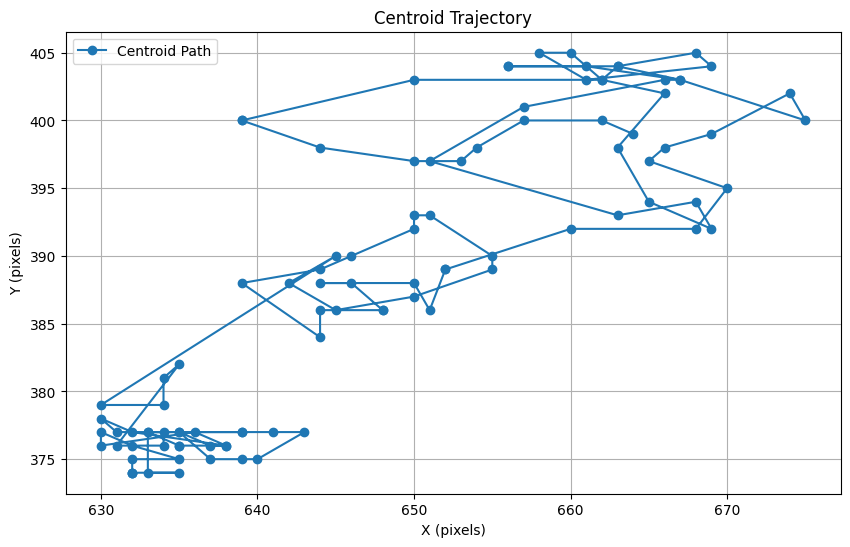

In [2]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd


# Utilities
def ensure_folder_exists(folder_path):
    """Ensure a folder exists; create it if it doesn't."""
    os.makedirs(folder_path, exist_ok=True)


def clear_folder(folder_path):
    """Delete all contents of a folder."""
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    ensure_folder_exists(folder_path)


# Frame Utilities
def get_video_frame_count(video_path):
    """Return the total number of frames in a video."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames


def extract_evenly_spaced_frames(video_path, output_folder, max_frames):
    """Extract evenly spaced frames from a video."""
    clear_folder(output_folder)
    cap = cv2.VideoCapture(video_path)
    total_frames = get_video_frame_count(video_path)
    frame_interval = max(1, total_frames // max_frames)
    saved_count = 0

    frame_idx = 0
    while cap.isOpened() and saved_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_interval == 0:
            frame_name = os.path.join(output_folder, f"frame_{saved_count:04d}.png")
            cv2.imwrite(frame_name, frame)
            saved_count += 1
        frame_idx += 1

    cap.release()
    print(f"Extracted {saved_count} frames to '{output_folder}'.")


# Centroid Utilities
def color_thresholding(image, lower_bounds, upper_bounds):
    """Apply color thresholding."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask


def detect_circle(image, mask):
    """Detect circle using Hough Transform."""
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    return circles[0, 0].astype("int") if circles is not None else None


def calculate_centroid(mask):
    """Calculate centroid of a binary mask."""
    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        return (cx, cy)
    return None


# Process Frames
def process_video_from_frames(output_folder, lower_bounds, upper_bounds, output_csv=None):
    """Process extracted frames to track centroids."""
    frame_files = sorted([f for f in os.listdir(output_folder) if f.endswith(".png")])
    centroids = []

    for frame_idx, frame_file in enumerate(frame_files):
        frame_path = os.path.join(output_folder, frame_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Error: Could not read frame {frame_path}. Skipping.")
            centroids.append(None)
            continue

        # Apply color thresholding
        mask = color_thresholding(frame, lower_bounds, upper_bounds)

        # Detect AO mask and calculate centroid
        centroid = calculate_centroid(mask)
        centroids.append(centroid)

    # Save centroids to CSV if required
    if output_csv:
        save_centroids_to_csv(centroids, output_csv)

    return centroids


def save_centroids_to_csv(centroids, csv_path):
    """Save centroids to a CSV file."""
    with open(csv_path, "w") as f:
        f.write("Frame,Centroid_X,Centroid_Y\n")
        for idx, centroid in enumerate(centroids):
            if centroid:
                f.write(f"{idx + 1},{centroid[0]},{centroid[1]}\n")
            else:
                f.write(f"{idx + 1},NaN,NaN\n")


def plot_centroid_trajectory(centroids, title="Centroid Trajectory"):
    """Plot trajectory of centroids."""
    x_coords = [c[0] if c else np.nan for c in centroids]
    y_coords = [c[1] if c else np.nan for c in centroids]
    plt.figure(figsize=(10, 6))
    plt.plot(x_coords, y_coords, label="Centroid Path", marker='o')
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


video_path = "./comp0241_data/single_rotation_top_view.mp4"
output_folder = "./comp0241_data/movement_frames"
csv_path = "./comp0241_data/output_centroids.csv"
lower_bounds = [np.array([20, 10, 150]), np.array([0, 0, 200])]
upper_bounds = [np.array([150, 255, 255]), np.array([180, 50, 255])]

# Ensure output folder exists
ensure_folder_exists(output_folder)

# Extract frames if not already done
if len(os.listdir(output_folder)) == 0:
    extract_evenly_spaced_frames(video_path, output_folder, max_frames=100)

# Process the frames and save centroids
centroids = process_video_from_frames(output_folder, lower_bounds, upper_bounds, output_csv=csv_path)

# Plot centroid trajectory
plot_centroid_trajectory(centroids)

Detected Globe Center: (X: 195, Y: 176), Radius: 101


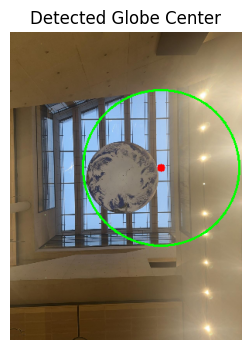

Resized Image 1 Shape: (400, 300)
Resized Image 2 Shape: (400, 300)
8.0


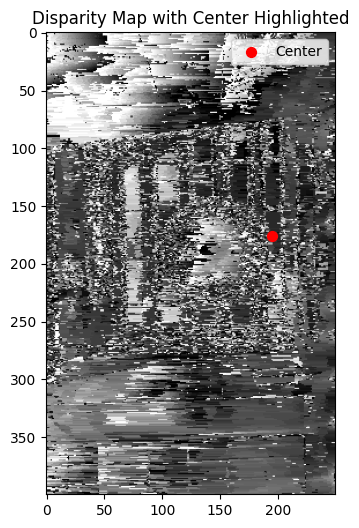

Disparity at the center: 8.00
Globe Height: 84.38 m


In [3]:
# Find globe center 
import cv2
import numpy as np
import matplotlib.pyplot as plt

def color_thresholding(image, lower_bounds, upper_bounds):
    """
    Apply color thresholding to segment the AO.
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

def refined_circle_detection_with_mask(image, color_mask):
    """
    Detect circles in the AO using the color mask.
    """
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=200,
        param1=50,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    mask = np.zeros_like(gray_image)
    if circles is not None:
        circle = np.uint16(np.around(circles[0, 0]))  # Use only the first detected circle
        x, y, r = circle
        cv2.circle(mask, (x, y), r, 255, -1)
        return x, y, r
    return None, None, None

# Load the stereo image pair
img1 = cv2.imread('./comp0241_data/globe-left.jpeg', cv2.IMREAD_COLOR)

# Validate image loading
if img1 is None:
    print("Error: Image not found or could not be loaded.")
    exit()

# Resize the image for processing
scaling_factor = 0.25
img1 = cv2.resize(img1, (0, 0), fx=scaling_factor, fy=scaling_factor)

# Define HSV color thresholds
lower_bounds = [
    np.array([20, 10, 150]),  
    np.array([0, 0, 200]),   
]
upper_bounds = [
    np.array([150, 255, 255]),
    np.array([180, 50, 255]),  # Corrected upper bound for HSV (V should be max 255)
]
# Apply color thresholding
color_mask = color_thresholding(img1, lower_bounds, upper_bounds)

# Detect the globe's center using the circle detection method
cx, cy, r = refined_circle_detection_with_mask(img1, color_mask)

# Visualize the results
if cx is not None and cy is not None:
    print(f"Detected Globe Center: (X: {cx}, Y: {cy}), Radius: {r}")
    cv2.circle(img1, (cx, cy), r, (0, 255, 0), 2)  # Draw the detected circle
    cv2.circle(img1, (cx, cy), 5, (0, 0, 255), -1)  # Draw the center
else:
    print("No globe detected.")

# Show the result
plt.figure(figsize=(6, 4))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Detected Globe Center")
plt.axis("off")
plt.show()

# # Visualize the color mask
# plt.figure(figsize=(10, 10))
# plt.imshow(color_mask, cmap="gray")
# plt.title("Color Mask")
# # plt.axis("off")
# plt.show()
# print


# Vectorized dynamic programming function to find the minimum cost path

def dynamicProgramVec(unaryCosts, pairwiseCosts):
    """
    Vectorized dynamic programming function to find the minimum cost path.

    Parameters:
    unaryCosts: np.ndarray
        Costs associated with each disparity for every position.
    pairwiseCosts: np.ndarray
        Costs associated with transitioning between disparities.

    Returns:
    bestPath: np.ndarray
        The optimal path of disparities for each position.
    """
    # Count the number of positions (pixels in the scanline) and nodes (disparities)
    nNodesPerPosition = len(unaryCosts)
    nPosition = len(unaryCosts[0])

    # Define minimum cost matrix
    minimumCost = np.zeros((nNodesPerPosition, nPosition))

    # Define parent matrix
    parents = np.zeros((nNodesPerPosition, nPosition), dtype=int)

    # Initialize the first column of the minimum cost matrix
    minimumCost[:, 0] = unaryCosts[:, 0]

    # Forward pass (vectorized)
    for cPosition in range(1, nPosition):
        # Expand the previous column to calculate costs for all transitions
        expanded_previous_cost = minimumCost[:, cPosition - 1][:, np.newaxis]  # Shape: (nNodesPerPosition, 1)

        # Calculate total costs for all transitions
        total_costs = expanded_previous_cost + pairwiseCosts + unaryCosts[:, cPosition][np.newaxis, :]  # Shape: (nNodesPerPosition, nNodesPerPosition)

        # Find the minimum cost and corresponding parent for each node
        minimumCost[:, cPosition] = np.min(total_costs, axis=0)
        parents[:, cPosition] = np.argmin(total_costs, axis=0)

    # Backward pass
    bestPath = np.zeros(nPosition, dtype=int)

    # Start from the minimum cost in the last column
    bestPath[-1] = np.argmin(minimumCost[:, -1])

    # Trace back using the parent matrix
    for cPosition in range(nPosition - 1, 0, -1):
        bestPath[cPosition - 1] = parents[bestPath[cPosition], cPosition]

    return bestPath

# Disparity Map with Center Highlighted

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo image pair in grayscale
img1 = cv2.imread('./comp0241_data/globe-left.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./comp0241_data/globe-right.jpeg', cv2.IMREAD_GRAYSCALE)

# Validate image loading
if img1 is None or img2 is None:
    print("Error: Images not found or could not be loaded.")
    exit()

# Resize images by a scaling factor
scaling_factor = 0.25  # Use 0.5 for half size or 0.25 for quarter size
img1 = cv2.resize(img1, (0, 0), fx=scaling_factor, fy=scaling_factor)
img2 = cv2.resize(img2, (0, 0), fx=scaling_factor, fy=scaling_factor)

# Display the resized images (optional)
print(f"Resized Image 1 Shape: {img1.shape}")
print(f"Resized Image 2 Shape: {img2.shape}")

# Normalize images for display purposes
im1show = img1.astype(float) / 255.0 if np.max(img1) > 1 else img1
im2show = img2.astype(float) / 255.0 if np.max(img2) > 1 else img2

# Parameters
maxDisp = 50  # Maximum disparity
alpha = 5  # Smoothness penalty
noiseSD = 1  # Standard deviation of noise

# Compute pairwise costs
pairwiseCosts = alpha * np.ones((maxDisp, maxDisp)) - alpha * np.eye(maxDisp)

# Initialize the disparity map
imY, imX = img1.shape
estDisp = np.zeros((imY, imX - maxDisp))

# Process each scanline
for cY in range(imY):
    # Extract slices for all disparities
    im1_slice = img1[cY, :imX - maxDisp]  # Fixed slice for img1
    im2_slices = np.array([
        img2[cY, cDisp:imX - maxDisp + cDisp] for cDisp in range(maxDisp)
    ])  # Stacked slices for each disparity
    
    # Compute unary costs
    diff = im1_slice - im2_slices  # Shape: (maxDisp, imX - maxDisp)
    unaryCosts = (diff**2) / (2 * (noiseSD**2))
    
    # Use dynamic programming to calculate disparity
    estDisp[cY, :] = np.transpose(dynamicProgramVec(unaryCosts, pairwiseCosts))


print(estDisp[cy,cx])
# Normalize and visualize the disparity map
plt.figure(figsize=(10, 6))
plt.imshow(estDisp, cmap='gray')

# Mark the center in red
plt.scatter(cx, cy, color='red', s=50, label='Center')

# Add title and legend
plt.title("Disparity Map with Center Highlighted")
plt.legend()
plt.show()

# Calculate Globe's Height using disparity

# Scale the focal length based on the resizing factor
original_focal_length = 1350.0  # Original focal length in pixels
scaling_factor = 0.25  # Scaling factor used when resizing the images
adjusted_focal_length = original_focal_length * scaling_factor

def calculate_distance(focal_length, baseline, disparity):
    """
    Calculate Globe's Height using disparity.

    Parameters:
        focal_length (float): The focal length of the camera in pixels.
        baseline (float): The baseline distance between the two cameras in m.
        disparity (float): The disparity value at the center pixel.

    Returns:
        float: The calculated distance to the object in m, or None if disparity is invalid.
    """
    if disparity <= 0:
        print("Invalid or zero disparity. Cannot calculate distance.")
        return None
    
    # Distance formula: Z = (f * B) / disparity
    distance = (focal_length * baseline) / disparity
    return distance


center_disparity = estDisp[cy,cx]

# Check if the disparity is valid
if center_disparity <= 0:
    print(f"Disparity at the center is invalid or zero: {center_disparity:.2f}")
else:
    print(f"Disparity at the center: {center_disparity:.2f}")


baseline = 2  # Baseline distance in m
disparity = estDisp[cy,cx]  # Disparity value from the center of the disparity map

distance = calculate_distance(adjusted_focal_length, baseline, disparity)
if distance is not None:
    print(f"Globe Height: {distance:.2f} m")

# Task 3
## Estimate the Rotation Cycle of the AO

### a) Explain Your Methodology
### b) Provide a Single Rotation Cycle Estimate as reference

In [ ]:
# No code needed here, the explanation is provided in the report.

### c) Continuous Rotation Cycle Estimation from Video
### d) Real-Time Rotation Cycle Estimation
### e) Compare Estimations from Different Views

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from scipy.signal import find_peaks

data_folder = './comp0241_data'
video_paths = [f"{data_folder}/single_rotation_top_view.mp4", f"{data_folder}/single_rotation_bottom_view.mp4", f"{data_folder}/multiple_rotations_top_view.mp4"]

for video_path in video_paths:
    print(f"Processing video: {video_path}")
    # Open the video
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    print(f"Frame rate: {frame_rate} fps")
    frame_interval = 10  # Process every 10th frame

    # Read the first frame
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Unable to read video.")

    # Define ROI (manually set or use a selection tool beforehand)
    x, y, w, h = [599, 180, 489, 449]  # Example ROI
    if w == 0 or h == 0:
        raise ValueError("No valid ROI selected.")

    # Extract ROI and detect features in the first frame
    first_roi = first_frame[y:y+h, x:x+w]
    gray_first_roi = cv2.cvtColor(first_roi, cv2.COLOR_BGR2GRAY)

    # Detect features in the first frame using SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray_first_roi, None)

    frame_idx = 0

    # Store good matches count for each processed frame
    matches_counts = []
    processed_frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video stream

        frame_idx += 1

        # Skip frames to process every 10th frame
        if frame_idx % frame_interval != 0:
            continue

        start = time.perf_counter()

        # Extract ROI from the current frame
        roi_frame = frame[y:y+h, x:x+w]
        gray_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

        # Detect features in the current frame
        kp2, des2 = sift.detectAndCompute(gray_roi_frame, None)
        if des2 is None:
            matches_counts.append(0)
            processed_frames.append(frame_idx)
            continue

        # Match features using FLANN
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Apply Lowe's ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Record the number of good matches
        matches_counts.append(len(good_matches))
        processed_frames.append(frame_idx)

        end = time.perf_counter()
        elapsed = end - start

        print(f"Frame {frame_idx}: {len(good_matches)} good matches, elapsed: {elapsed:.3f}s")

    cap.release()

    # Convert frame indices to time
    processed_times = np.array(processed_frames) / frame_rate

    # Find peaks in the matches_counts array
    # Adjust parameters as needed (e.g., prominence, height) to reliably find peaks
    peaks, _ = find_peaks(matches_counts, prominence=100, distance=50)  # Try different prominence values
    peaks = np.insert(peaks, 0, 0.0)

    if len(peaks) < 2:
        print("Not enough peaks found to estimate multiple rotations.")
    else:
        
        # Calculate rotation periods between consecutive peaks
        rotation_times = processed_times[peaks]
        intervals = np.diff(rotation_times)  # time differences between peaks

        # Number of rotations is basically the number of peaks - 1 (assuming the first peak as the first complete rotation)
        num_rotations = len(peaks) - 1
        avg_rotation_period = np.mean(intervals) if num_rotations > 0 else None

        print(f"Detected {len(peaks)} peaks at times: {rotation_times}")
        if avg_rotation_period is not None:
            print(f"Number of full rotations: {num_rotations}")
            print(f"Average rotation period: {avg_rotation_period:.2f} seconds")
        else:
            print("Only one peak found, cannot compute rotation period.")

    # Plotting the matches over time
    plt.figure(figsize=(10, 5))
    plt.plot(processed_times, matches_counts, label=f'Number of matches')
    if len(peaks) > 0:
        plt.plot(processed_times[peaks], np.array(matches_counts)[peaks], 'ro', label='Peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Matches')
    plt.title(f'[{video_path}] Number of full rotations: {num_rotations}, Average rotation period: {avg_rotation_period:.2f} seconds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Task 4
# Bonus Objective: Estimate the Landing Speed in the Earth's Coordinate Frame of the Drone

### a) Estimate the AO's Diameter

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Functions for calculations
def find_camera_params(diameter_pixels, diameter_meters, distance_meters, image_width, image_height):
    # Calculate the focal length in pixels
    focal_length = (diameter_pixels * distance_meters) / diameter_meters
    print(f"Focal length in pixels: {focal_length:.2f}")

    # Assume the camera principal point (cx, cy) is the image center
    cx = image_width / 2
    cy = image_height / 2

    # Intrinsic camera matrix
    camera_matrix = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ])

    return camera_matrix, focal_length

def find_real_size(focal_length, size_pixel, distance_meters):
    return (size_pixel * distance_meters) / focal_length

def find_distance(focal_length, size_pixel, size_real):
    return (focal_length * size_real) / size_pixel

# Function to perform color thresholding
def color_thresholding(image, lower_bounds, upper_bounds):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

# Function to perform refined circle detection
def refined_circle_detection_with_mask(image, color_mask):
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (11, 11), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=50,
        param1=50,
        param2=30,
        minRadius=50,
        maxRadius=500,
    )
    if circles is not None:
        return np.uint16(np.around(circles))[0, 0]  # First circle (x, y, radius)
    return None

# Inputs
image_path = "./comp0241_data/4ab.jpg"
resize_factor = 0.25  # Resize image to speed up processing

# Camera matrix and focal length
#(array([[1.93142857e+03, 0.00000000e+00, 2.16000000e+03],
#        [0.00000000e+00, 1.93142857e+03, 3.84000000e+03],
#        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
# 1931.4285714285713)
distance_to_globe = 5.0  # Distance to the globe in meters
focal_length = 1931.43

# Lower and upper bounds for color thresholding
lower_bounds = [
    np.array([10, 0, 0]),  # Example for specific hue
    np.array([0, 0, 200])  # Bright whites
]
upper_bounds = [
    np.array([150, 250, 200]),  # Saturated color range
    np.array([180, 50, 255])    # Bright whites
]

# Read and resize the image
frame = cv2.imread(image_path)
if frame is None:
    raise ValueError("Unable to read the image.")
height, width, channels = frame.shape
frame = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)

# Apply color thresholding
binary_mask = color_thresholding(frame, lower_bounds, upper_bounds)

# Apply refined circle detection
circle_params = refined_circle_detection_with_mask(frame, binary_mask)
if circle_params is None:
    raise ValueError("No circle detected.")
x, y, r = circle_params  # Center (x, y) and radius

# Draw the circle and center
output_image = frame.copy()
cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Globe circle
cv2.circle(output_image, (x, y), 5, (0, 0, 255), -1)  # Center point

# Plot horizontal diameter
left_x = x - r
right_x = x + r
cv2.line(output_image, (left_x, y), (right_x, y), (255, 0, 0), 2)  # Diameter line

# Calculate and display diameter
diameter_pixels = 2 * r
print(f"Diameter in pixels (after resizing): {diameter_pixels}")

# Scale back to original size for correct interpretation
original_diameter_pixels = diameter_pixels / resize_factor
print(f"Diameter in pixels (original resolution): {original_diameter_pixels}")

# Calculate real size (validation)
real_diameter_calculated = find_real_size(focal_length, original_diameter_pixels, distance_to_globe)
print(f"Real diameter calculated: {real_diameter_calculated:.4f} meters")

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Globe Detection\nDiameter: {real_diameter_calculated:.2f} m")
plt.axis("off")
plt.show()


### b) Evaluate Radius Consistency

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Functions for calculations
def find_real_size(focal_length, size_pixel, distance_meters):
    return (size_pixel * distance_meters) / focal_length

# Function to perform color thresholding
def color_thresholding(image, lower_bounds, upper_bounds):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
        mask |= cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask

# Refined circle detection to create a mask
def refined_circle_detection_with_mask(image, color_mask):
    masked_image = cv2.bitwise_and(image, image, mask=color_mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    circles = cv2.HoughCircles(
        blurred_image,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=200,
        param1=150,
        param2=40,
        minRadius=30,
        maxRadius=400,
    )
    mask = np.zeros_like(gray_image)
    if circles is not None:
        circle = np.round(circles[0, 0]).astype("int")
        x, y, r = circle
        cv2.circle(mask, (x, y), r, 255, -1)
    return mask

# Find center and radii based on the mask
def find_mask_center_and_radii(mask):
    white_pixels = np.column_stack(np.where(mask == 255))
    if len(white_pixels) == 0:
        return None, None, None, None, None, None

    # Find center
    center_y, center_x = white_pixels.mean(axis=0)
    center_x, center_y = int(center_x), int(center_y)

    # Compute radii
    # Left and right
    row_pixels = np.where(mask[center_y, :] == 255)[0]
    left_radius = center_x - row_pixels[0]
    right_radius = row_pixels[-1] - center_x

    # Top and bottom
    col_pixels = np.where(mask[:, center_x] == 255)[0]
    top_radius = center_y - col_pixels[0]
    bottom_radius = col_pixels[-1] - center_y

    return center_x, center_y, left_radius, right_radius, top_radius, bottom_radius

# Inputs
image_path = "./comp0241_data/4ab.jpg"
resize_factor = 0.25  # Resize image for performance
distance_to_globe = 5.0  # Distance to the globe in meters
focal_length = 1931.43  # Focal length in pixels

# Lower and upper bounds for color thresholding
lower_bounds = [
    np.array([10, 0, 0]),
    np.array([0, 0, 200])
]
upper_bounds = [
    np.array([150, 250, 200]),
    np.array([180, 50, 255])
]

# Read and resize the image
frame = cv2.imread(image_path)
if frame is None:
    raise ValueError("Unable to read the image.")
height, width, channels = frame.shape
frame = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)

# Apply color thresholding and refined circle detection
binary_mask = color_thresholding(frame, lower_bounds, upper_bounds)
circle_mask = refined_circle_detection_with_mask(frame, binary_mask)

# Find center and radii
center_x, center_y, left_radius, right_radius, top_radius, bottom_radius = find_mask_center_and_radii(circle_mask)
if center_x is None:
    raise ValueError("No valid mask or radii found.")

# Convert radii to real-world meters
real_radius_left = find_real_size(focal_length, left_radius // resize_factor, distance_to_globe)
real_radius_right = find_real_size(focal_length, right_radius // resize_factor, distance_to_globe)
real_radius_top = find_real_size(focal_length, top_radius // resize_factor, distance_to_globe)
real_radius_bottom = find_real_size(focal_length, bottom_radius // resize_factor, distance_to_globe)

# Check uniformity of radii
radii = [real_radius_left, real_radius_right, real_radius_top, real_radius_bottom]
uniform = max(radii) - min(radii) < 0.01  # Uniform if difference < 1cm
ratios = [radius / max(radii) for radius in radii]

# Draw visualization
output_image = frame.copy()
#cv2.circle(output_image, (center_x, center_y), left_radius, (0, 255, 0), 2)
#cv2.circle(output_image, (center_x, center_y), 5, (0, 0, 255), -1)
cv2.line(output_image, (center_x - left_radius, center_y), (center_x + right_radius, center_y), (255, 0, 0), 2)
cv2.line(output_image, (center_x, center_y - top_radius), (center_x, center_y + bottom_radius), (255, 0, 0), 2)

# Display results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(
    f"Radii: Left={real_radius_left:.2f}m, Right={real_radius_right:.2f}m\n"
    f"Top={real_radius_top:.2f}m, Bottom={real_radius_bottom:.2f}m\n"
    f"Uniform: {'Yes' if uniform else 'No'}\n"
    f"Ratios: L={ratios[0]:.2f}, R={ratios[1]:.2f}, T={ratios[2]:.2f}, B={ratios[3]:.2f}"
)
plt.axis("off")
plt.show()


### c) Calculate Surface Linear Velocity
### d) Real-Time Velocity Adjustments

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Hardcoded ROI
x, y, w, h = 618, 220, 444, 386  # ROI coordinates

video_path = './comp0241_data/single_rotation_top_view.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    raise ValueError("FPS could not be retrieved. Check the video file.")
frame_time = 1 / fps

# Process only the first 30 seconds
max_duration = 360  # seconds
max_frames = int(fps * max_duration)

# Rotation constants
rotation_period = 326  # 5 minutes 26 seconds (in seconds)
angular_velocity = 2 * np.pi / rotation_period  # Angular velocity (radians/second)

# Detect globe in the first frame
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Unable to read video.")
gray_first = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Extract ROI from the first frame
roi_first = gray_first[y:y+h, x:x+w]

# Detect the globe using Hough Circles
circles = cv2.HoughCircles(
    roi_first,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=50,
    param1=50,
    param2=30,
    minRadius=100,
    maxRadius=250,
)

if circles is None:
    raise ValueError("No globe detected within the ROI.")
circles = np.uint16(np.around(circles))[0, 0]  # Take the first detected circle
circle_center = (circles[0], circles[1])  # (x, y) center of the circle
circle_radius = circles[2]  # Radius of the globe

# Create a circular mask for the globe
mask = np.zeros_like(roi_first, dtype=np.uint8)
cv2.circle(mask, circle_center, circle_radius, 255, -1)

# Use SIFT for feature detection within the mask (only in the first frame)
sift = cv2.SIFT_create(nfeatures=5000)
kp = sift.detect(roi_first, mask)
if len(kp) == 0:
    raise ValueError("No features detected within the globe mask.")

# Convert keypoints to numpy array of shape (N, 2), adjusting to global coords
features = np.array([kp_.pt for kp_ in kp], dtype=np.float32)
features_global = features.copy()
features_global[:, 0] += x
features_global[:, 1] += y

# Enforce maximum number of tracked features
max_features = 100  # Limit for maximum tracked features
if len(features_global) > max_features:
    features_global = features_global[np.random.choice(len(features_global), max_features, replace=False)]

# Ensure all selected features are inside the circular mask
distances = np.linalg.norm(features_global - np.array([x + circle_center[0], y + circle_center[1]]), axis=1)
features_global = features_global[distances <= circle_radius]

# Initialize tracking
all_positions = [features_global]
prev_gray = gray_first
frame_count = 0

# Precompute velocity map using the mask radius
grid_size_x, grid_size_y = 50, 50  # Grid resolution
velocity_map = np.zeros((grid_size_y, grid_size_x))  # Initialize velocity map

# Calculate tangential velocity for each grid cell
y_center = grid_size_y // 2  # Vertical center of the grid (equator)
for j in range(grid_size_y):
    for i in range(grid_size_x):
        relative_y = (j - y_center) / (grid_size_y // 2)  # Normalized latitude
        if abs(relative_y) <= 1.0:
            latitude = np.arcsin(relative_y)
            velocity_map[j, i] = angular_velocity * circle_radius * np.cos(latitude)  # Tangential velocity
        else:
            velocity_map[j, i] = 0  # Outside the circle

# Plot the velocity map
plt.figure(figsize=(8, 6))
plt.imshow(velocity_map, cmap='jet', extent=(0, grid_size_x, grid_size_y, 0), norm=Normalize())
plt.colorbar(label="Velocity (pixels/s)")
plt.title("Expected Tangential Velocity Distribution")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.gca().invert_yaxis()
plt.show()

# Normalize velocity map for color mapping
norm = Normalize(vmin=velocity_map.min(), vmax=velocity_map.max())

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count > max_frames:
        # Stop after 30 seconds
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Track features using optical flow
    p0 = all_positions[-1].astype(np.float32)
    # Convert p0 to ROI coords for optical flow
    p0_roi = p0.copy()
    p0_roi[:, 0] -= x
    p0_roi[:, 1] -= y

    new_features, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray[y:y+h, x:x+w],
        gray[y:y+h, x:x+w],
        p0_roi,
        None
    )

    if new_features is None:
        # No new features tracked
        break

    valid_new_roi = new_features[status.flatten() == 1]
    valid_old_roi = p0_roi[status.flatten() == 1]

    # Convert back to global coords
    valid_new = np.zeros_like(valid_new_roi)
    valid_new[:, 0] = valid_new_roi[:, 0] + x
    valid_new[:, 1] = valid_new_roi[:, 1] + y

    # Draw the points with colors based on their velocity from the velocity map
    display_frame = frame.copy()
    for new in valid_new_roi:
        grid_x = int(new[0] / (w / grid_size_x))
        grid_y = int(new[1] / (h / grid_size_y))
        if 0 <= grid_x < grid_size_x and 0 <= grid_y < grid_size_y:
            velocity = velocity_map[grid_y, grid_x]
            color = cm.jet(norm(velocity))[:3]  # Normalize velocity to color map
            color_bgr = tuple(int(c * 255) for c in color[::-1])  # Convert to BGR
            x_new, y_new = int(new[0] + x), int(new[1] + y)
            cv2.circle(display_frame, (x_new, y_new), 3, color_bgr, -1)
            cv2.putText(display_frame, f"{velocity:.1f} px/s", (x_new + 5, y_new - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

    # Draw detected globe
    #cv2.circle(display_frame[y:y+h, x:x+w], circle_center, circle_radius, (255, 0, 0), 2)

    # Show the video with tracked points and colors
    cv2.imshow('Video with Tracked Points', display_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update for next iteration
    prev_gray = gray
    all_positions.append(valid_new)

cap.release()
cv2.destroyAllWindows()